In [2]:
import re
import json
import numpy as np
import pandas as pd
from plotnine import *
from pathlib import Path
from loguru import logger
from copy import deepcopy
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool
from common_metrics.metrics.recsys import MAP, HitRate, NDCG, PrecisionRecall
from sklearn.model_selection import train_test_split
import scipy.sparse as sp
import json  
from typing import List

In [6]:
# path_raw_data = '/mnt/new_products/y.konyushenko/diplom_output/raw_data/transaction_history.csv.gz'
# raw_data = pd.read_csv(path_raw_data, sep=",", compression="gzip")

In [11]:
# path_to_dataset = '/mnt/new_products/y.konyushenko/diplom_output/dataset/perfect_data_1000_users'

In [13]:
# import os
# train = pd.read_csv(os.path.join(path_to_dataset, "train.csv"))
# test = pd.read_csv(os.path.join(path_to_dataset, "test.csv"))

In [35]:
# from scipy import sparse
# n_items = len(train.item.unique())
# n_users = len(train.user.unique())
# rows, cols = train["user"], train["item"]
# data = sparse.csr_matrix((np.ones_like(rows), (rows, cols)), dtype="float64", shape=(max(rows) + 1, max(cols) + 1))

In [38]:
# загружаю рейтинги
ratings_lf = sp.load_npz('/mnt/new_products/y.konyushenko/diplom_output/second_level_data/ratings_lightfm.npz')
ratings_ease = sp.load_npz('/mnt/new_products/y.konyushenko/diplom_output/second_level_data/ratings_ease.npz')
ratings_recvae = sp.load_npz('/mnt/new_products/y.konyushenko/diplom_output/second_level_data/ratings_recvae.npz')

assert ratings_lf.shape == ratings_ease.shape == ratings_recvae.shape 

# загружаю рекоммендации
f_lf = open('/mnt/new_products/y.konyushenko/diplom_output/model_recommendations/light_fm/recommend.json')
rec_lf = json.load(f_lf)
rec_lf = dict(rec_lf)

f_ease = open('/mnt/new_products/y.konyushenko/diplom_output/model_recommendations/ease/recommend.json')
rec_ease = json.load(f_ease)
rec_ease = dict(rec_ease)

f_recvae = open('/mnt/new_products/y.konyushenko/diplom_output/model_recommendations/recvae/recommend.json')
rec_recvae = json.load(f_recvae)
rec_recvae = dict(rec_recvae)

assert len(rec_recvae) == len(rec_ease) == len(rec_lf)

In [39]:
n_rec = 100. 

In [40]:
recommend_lf = pd.DataFrame(rec_lf.items(), columns=['user', 'item'])
recommend_lf = recommend_lf.explode('item')
recommend_lf['rank'] = list(np.arange(n_rec)) * ratings_lf.shape[0]
recommend_lf['score'] = ratings_lf.reshape([-1, 1]).toarray()
recommend_lf.to_csv("/mnt/new_products/y.konyushenko/diplom_output/second_level_data/data_lf.csv.gz", index=None, compression="gzip")

recommend_ease = pd.DataFrame(rec_ease.items(), columns=['user', 'item'])
recommend_ease = recommend_ease.explode('item')
recommend_ease['rank'] = list(np.arange(n_rec)) * ratings_ease.shape[0]
recommend_ease['score'] = ratings_ease.reshape([-1, 1]).toarray()
recommend_ease.to_csv("/mnt/new_products/y.konyushenko/diplom_output/second_level_data/data_ease.csv.gz", index=None, compression="gzip")

recommend_recvae = pd.DataFrame(rec_recvae.items(), columns=['user', 'item'])
recommend_recvae = recommend_recvae.explode('item')
recommend_recvae['rank'] = list(np.arange(n_rec)) * ratings_recvae.shape[0]
recommend_recvae['score'] = ratings_recvae.reshape([-1, 1]).toarray()
recommend_recvae.to_csv("/mnt/new_products/y.konyushenko/diplom_output/second_level_data/data_recvae.csv.gz", index=None, compression="gzip")


In [80]:
# from typing import Type
# import numpy as np
# import pandas as pd
# from pathlib import Path
# from loguru import logger
# from scipy.sparse import csr_matrix
# from dataclasses import dataclass, field
# from sklearn.preprocessing import LabelEncoder


# @dataclass
# class Encoder:
#     """Encoder class to prepare data, like encoding users and items."""

#     user: LabelEncoder = field(default_factory=LabelEncoder)
#     item: LabelEncoder = field(default_factory=LabelEncoder)

#     @property
#     def is_fitted(self):
#         return hasattr(self.item, "classes_")

#     def fit(self, data: pd.DataFrame) -> None:
#         for attr, encoder in self.__dict__.items():
#             logger.info(f"Fitting {attr} encoder.")
#             encoder.fit(data[attr])

#     def transform(self, data: pd.DataFrame) -> pd.DataFrame:
#         data_copy = data.copy()
#         data_copy = data_copy[
#             data_copy.user.isin(self.user.classes_) & data_copy.item.isin(self.item.classes_)
#         ]
#         for attr, encoder in self.__dict__.items():
#             logger.info(f"Transforming {attr}.")
#             data_copy[attr] = encoder.transform(data_copy[attr])
#         return data_copy

#     def fit_transform(self, data: pd.DataFrame) -> pd.DataFrame:
#         self.fit(data)
#         return self.transform(data)

#     def to_sparse(self, data: pd.DataFrame, norm: bool = False) -> csr_matrix:
#         # Convenient asserts to check class and passed data
#         # and if needed change something
#         if not (hasattr(self.user, "classes_") and hasattr(self.item, "classes_")):
#             raise Exception("Both user and item encoders needs to be fitted to make sparse matrix.")
#         data = data[
#             data.user.isin(self.user.classes_) & data.item.isin(self.item.classes_)
#         ]
#         for attr, encoder in filter(lambda x: data[x[0]].dtypes != int, self.__dict__.items()):
#             logger.info(f"Transforming {attr}.")
#             data[attr] = encoder.transform(data[attr])
#         logger.info("Building sparse matrix.")
#         shape = len(self.user.classes_), len(self.item.classes_)
#         values = (
#             data.value / max(np.linalg.norm(data.value), 1e-13) if norm else data.value.to_numpy()
#         )
#         return csr_matrix((values, (data.user.to_numpy(), data.item.to_numpy())), shape=shape)

#     @classmethod
#     def from_encoders(cls: Type["Encoder"], encoders_path: Path) -> "Encoder":
#         user_encoder = encoders_path / "user_classes.npy"
#         item_encoder = encoders_path / "item_classes.npy"
#         _encoder = cls()
#         _encoder.user.classes_ = np.load(user_encoder, allow_pickle=True)
#         _encoder.item.classes_ = np.load(item_encoder, allow_pickle=True)
#         return _encoder

In [41]:
from sklearn.preprocessing import LabelEncoder

user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

In [85]:
# test_data = pd.read_csv("/mnt/new_products/y.konyushenko/diplom/raw-data/test.csv", sep="\t")

In [86]:
# print(len(test_data['user'].unique()))
# print(len(test_data['item'].unique()))

2917180
2895


In [11]:
test_data = pd.read_csv("/mnt/new_products/y.konyushenko/diplom_output/raw_data/transaction_history.csv.gz", sep=",", compression="gzip")
test_data

,user_id,instrument_tiker,cnt,is_train,is_valid
0,1-10YO9Z9,GAZP,0.889090,True,False
1,1-10YO9Z9,RUAL,0.590378,True,False
2,1-10YO9Z9,MTLR,0.746282,True,False
3,1-10YO9Z9,CHMF,0.440050,True,False
4,1-10YO9Z9,VTBR,0.358887,True,False
...,...,...,...,...,...
36208674,5-ZZF16B31,CLOV,0.271375,True,False
36208675,5-ZZF16B31,WKHS,0.210464,True,False
36208676,5-ZZF16B31,AAPL,0.338253,True,False
36208677,5-ZZF16B31,INTC,0.478754,True,False


In [5]:
print(len(test_data['user_id'].unique()))
print(len(test_data['instrument_tiker'].unique()))

2261086
1822


In [21]:
np.sum(test_data['user_id'].value_counts().values)

36208679

In [56]:
test_data = pd.read_csv("/mnt/new_products/y.konyushenko/diplom_output/raw_data/transaction_history.csv.gz", sep=",", compression="gzip")

source_data = test_data[test_data.is_train == True]
user_item_answer = {
    (str(row[0]), str(row[1])): int(row[2] > 0)
    for row in test_data[test_data.is_valid == True].values
}

source_data["target"] = [
    user_item_answer.get((str(row[0]), str(row[1])), 0) for row in source_data.values
]

source_data.drop(["is_train", "is_valid"], axis=1, inplace=True)
source_data.rename(columns = {'user_id': 'user', 'instrument_tiker': 'item'}, inplace = True)
source_data.to_csv("/mnt/new_products/y.konyushenko/diplom_output/second_level_data/data.csv.gz", sep="\t", index=None, compression="gzip")

/home/y.konyushenko/venv/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/y.konyushenko/venv/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/y.konyushenko/venv/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [57]:
source_data.head()

,user,item,cnt,target
0,1-10YO9Z9,GAZP,0.889090,0
1,1-10YO9Z9,RUAL,0.590378,0
2,1-10YO9Z9,MTLR,0.746282,0
3,1-10YO9Z9,CHMF,0.440050,0
4,1-10YO9Z9,VTBR,0.358887,0


In [58]:
path = "/mnt/new_products/y.konyushenko/diplom_output/second_level_data/data.csv.gz"
data_paths = {"train": path}
for key, path in data_paths.items():
    logger.info(f"Loading {key} dataset at {path}")
    data = pd.read_csv(path, sep="\t", compression="gzip")
    data.user = data.user.astype(str)
    data.item = data.item.astype(str)
    data_paths[key] = data
# encoder = Encoder()
unique_item = list(data_paths["train"]['item'].unique())
unique_user = list(data_paths["train"]['user'].unique())
data_paths["train"]["user"] = user_encoder.fit_transform(data_paths["train"]["user"])
data_paths["train"]["item"] = item_encoder.fit_transform(data_paths["train"]["item"])

2022-06-02 11:19:15.648 | INFO     | __main__:<module>:4 - Loading train dataset at /mnt/new_products/y.konyushenko/diplom_output/second_level_data/data.csv.gz


In [59]:
models_data_paths = {
    "light_fm": "/mnt/new_products/y.konyushenko/diplom_output/second_level_data/data_lf.csv.gz",
    "recvae": "/mnt/new_products/y.konyushenko/diplom_output/second_level_data/data_recvae.csv.gz",
    "ease": "/mnt/new_products/y.konyushenko/diplom_output/second_level_data/data_ease.csv.gz",
#     "cf": "/mnt/new_products/y.konyushenko/diplom_output/second_level_data/data_cf.csv.gz"
}
for model, path in models_data_paths.items():
    logger.info(f"Loading scores from {model} at {path}")
    data = pd.read_csv(path, compression="gzip")
    data.user = data.user.astype(str)
    data.item = data.item.astype(str)
    # There is a function called rank for pd.DataFrame.
    data["rank"] = data["rank"].astype(int)
    data['user'] = user_encoder.transform(data['user'])
    data['item'] = item_encoder.transform(data['item'])
    data.columns = [f"{model}-{x}" for x in list(data.columns)]
    models_data_paths[model] = data

2022-06-02 11:20:30.515 | INFO     | __main__:<module>:8 - Loading scores from light_fm at /mnt/new_products/y.konyushenko/diplom_output/second_level_data/data_lf.csv.gz
2022-06-02 11:21:40.051 | INFO     | __main__:<module>:8 - Loading scores from recvae at /mnt/new_products/y.konyushenko/diplom_output/second_level_data/data_recvae.csv.gz
2022-06-02 11:22:50.910 | INFO     | __main__:<module>:8 - Loading scores from ease at /mnt/new_products/y.konyushenko/diplom_output/second_level_data/data_ease.csv.gz


In [60]:
assert len(models_data_paths['ease']) == len(models_data_paths['recvae']) == len(models_data_paths['light_fm'])

In [61]:
for key, df_type in data_paths.items():
    for model, df_model in models_data_paths.items():
        logger.debug(f"Joining dataset from {model}")
        # Left join models and drop extra added columns excpet rank and value from the model dataframe.
        data_paths[key] = data_paths[key].merge(
            right=df_model,
            how="left",
            left_on=["user", "item"],
            right_on=[f"{model}-user", f"{model}-item"],
        ).drop(
            [
                x for x in list(df_model.columns)
                if re.search(r"(?:user|item)", x, flags=re.I) is not None
            ],
            axis=1,
        )
    # Drop rows with missing values in all of the models
    data_paths[key].dropna(
        how="all",
        subset=[f"{model}-score" for model in models_data_paths],
        inplace=True,
    )
#     # Then fill missing values in rank and value
    data_paths[key].fillna(
        value={
            **{f"{model}-rank": 1000 for model in models_data_paths},
            **{f"{model}-score": 1e-3 for model in models_data_paths},
        },
        inplace=True,
    )

2022-06-02 11:24:13.292 | DEBUG    | __main__:<module>:3 - Joining dataset from light_fm
2022-06-02 11:24:54.309 | DEBUG    | __main__:<module>:3 - Joining dataset from recvae
2022-06-02 11:25:28.753 | DEBUG    | __main__:<module>:3 - Joining dataset from ease


In [62]:
pivoted_train = data_paths["train"].pivot_table(index=["user", "item"])
pivoted_train.head()

cnt  ease-rank  ease-score  light_fm-rank  light_fm-score  \
user item                                                                   
0    42    0.001775        9.0    0.270761           67.0        1.576705   
     74    0.051837       42.0    0.134889            2.0        3.339408   
     213   0.003765       41.0    0.143464           59.0        1.638752   
     363   0.050366       60.0    0.100761           40.0        1.850287   
     558   0.609653       13.0    0.251636            0.0        4.437082   

           recvae-rank  recvae-score  target  
user item                                     
0    42            4.0      4.451427       0  
     74           27.0      3.743450       0  
     213           9.0      4.253369       0  
     363          23.0      3.799922       0  
     558           2.0      4.652764       1

In [63]:
for df_type, df in data_paths.items():
    for column in (c for c in list(data_paths["train"].columns) if "rank" in c):
        data_paths[df_type][column] = df[column].astype(int)

Прибавляю фичи по предсказанию доходности

In [53]:
# kats_features = pd.read_csv('kats_features.csv')
# kats_features["item"] = kats_features["item"].astype(str)
# unseen_items = list(set(kats_features_item) - set(unique_item))
# kats_features = kats_features.loc[~kats_features['item'].isin(unseen_items)]
# kats_features.to_csv('kats_features.csv', index=False)

In [54]:
kats_features = pd.read_csv('kats_features.csv')
kats_features["item"] = kats_features["item"].astype(str)
kats_features_item = list(kats_features["item"].unique())
unseen_items = list(set(kats_features_item) - set(unique_item))
kats_features = kats_features.loc[~kats_features['item'].isin(unseen_items)]
kats_features['item'] = item_encoder.transform(kats_features['item'])

kats_features.head()

,item,rt116,pred_revenue,binary_revenue
0,2347,32.814083,0.995144,-1
1,1507,293.126830,1.001538,1
2,909,124.507164,1.003688,1
3,945,31.533237,0.996843,-1
4,328,203.190540,1.002781,1


In [55]:
for key, df_type in data_paths.items():
    data_paths[key] = data_paths[key].merge(
        right=kats_features,
        how="left",
        left_on=["item"],
        right_on=["item"],
    )
# Drop rows with missing values in all of the models
# data_paths[key].dropna(
#     how="all",
#     subset=[""],
#     inplace=True,
# )
#     # Then fill missing values in rank and value
data_paths[key].fillna(
    value={
        **{"rt116": 0 },
        **{"pred_revenue": 1},
        **{"binary_revenue": 0}
    },
    inplace=True,
)

In [56]:
data_paths['train']

,user,item,target,light_fm-rank,light_fm-score,recvae-rank,recvae-score,ease-rank,ease-score,rt116,pred_revenue,binary_revenue
0,879620,2496,0,3,5.151402,5,5.178272,3,0.394497,0.0,1.0,0.0
1,1484024,159,0,8,3.377561,5,6.302424,33,0.111721,0.0,1.0,0.0
2,1364077,1411,0,79,1.999157,64,3.158238,1000,0.001000,0.0,1.0,0.0
3,2494471,2494,0,1,5.617161,0,7.404613,2,0.224709,0.0,1.0,0.0
4,1953586,723,0,5,3.463008,11,5.998730,1000,0.001000,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1673425,1690705,723,1,27,2.735167,38,3.608383,29,0.697456,0.0,1.0,0.0
1673426,2206074,1542,0,73,0.654113,14,2.499954,1000,0.001000,0.0,1.0,0.0
1673427,703802,1528,0,98,1.095691,72,2.752536,1000,0.001000,0.0,1.0,0.0
1673428,2068514,728,0,11,3.235396,18,4.523243,25,0.244287,0.0,1.0,0.0


Прибавляю фичи Пульса

In [57]:
path_pulse = '/mnt/new_products/y.konyushenko/diplom_output/second_level_data/pulse_features/pulse_features.csv.gz'
pulse_features= pd.read_csv(path_pulse, sep=",", compression="gzip")

In [58]:
pulse_features.head()

,user,item,count_proportion
0,62708078,MDLZ,0.003759
1,44144776,AVGO,0.016129
2,44144776,AVGO,0.016129
3,44144776,AVGO,0.016129
4,50846765,CVX,0.000518


In [32]:
# pulse_unique_items = pulse_features['item'].unique() 
# print('n_items', len(unique_item))
# print('pulse_unique_items', len(pulse_unique_items))
# print('n_items - pulse_unique_items', len(set(unique_item) - set(pulse_unique_items)))
# print('pulse_unique_items - n_items', len(set(pulse_unique_items) - set(unique_item)))

n_items 2885
pulse_unique_items 2109
n_items - pulse_unique_items 1003
pulse_unique_items - n_items 227


In [59]:
pulse_features["item"] = pulse_features["item"].astype(str)
pulse_features["user"] = pulse_features["user"].astype(str)
pulse_unique_items = pulse_features['item'].unique() 
unseen_items = list(set(pulse_unique_items) - set(unique_item))
pulse_features = pulse_features.loc[~pulse_features['item'].isin(unseen_items)]
pulse_features = pulse_features.loc[pulse_features['user'].isin(unique_user)]

In [60]:
%%time
pulse_features['user'] = user_encoder.transform(pulse_features['user'])
pulse_features['item'] = item_encoder.transform(pulse_features['item'])

CPU times: user 8.79 s, sys: 289 ms, total: 9.08 s
Wall time: 9.07 s


In [65]:
for key, df_type in data_paths.items():
    data_paths[key] = data_paths[key].merge(
        right=pulse_features,
        how="left",
        left_on=["item", "user"],
        right_on=["item", "user"],
    )
# Drop rows with missing values in all of the models
# data_paths[key].dropna(
#     how="all",
#     subset=[""],
#     inplace=True,
# )
#     # Then fill missing values in rank and value
data_paths[key].fillna(
    value={
        **{"count_proportion": 0 }
       
    },
    inplace=True,
)

In [66]:
data_paths[key][data_paths[key]['count_proportion'] != 0]

,user,item,target,light_fm-rank,light_fm-score,recvae-rank,recvae-score,ease-rank,ease-score,rt116,pred_revenue,binary_revenue,count_proportion
7,732167,2504,0,8,5.406071,11,4.475031,11,0.842382,0.0,1.0,0.0,0.030303
8,732167,2504,0,8,5.406071,11,4.475031,11,0.842382,0.0,1.0,0.0,0.030303
10,782653,1435,0,0,5.625191,4,4.926293,7,0.378850,0.0,1.0,0.0,0.666667
11,782653,1435,0,0,5.625191,4,4.926293,7,0.378850,0.0,1.0,0.0,0.666667
104,1101665,2875,0,55,1.015016,25,3.259886,1000,0.001000,0.0,1.0,0.0,0.090909
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1736645,2848648,2757,0,19,3.139005,16,3.608609,20,0.561518,0.0,1.0,0.0,0.076923
1736646,2848648,2757,0,19,3.139005,16,3.608609,20,0.561518,0.0,1.0,0.0,0.076923
1736693,1030333,312,1,37,2.865790,55,2.966202,36,0.767204,0.0,1.0,0.0,0.025145
1736694,1030333,312,1,37,2.865790,55,2.966202,36,0.767204,0.0,1.0,0.0,0.025145


In [64]:
if "valid" not in data_paths:
    all_users = data_paths["train"].user.unique()
    train_users, valid_users = train_test_split(all_users, test_size=0.2, random_state=13)
    data_paths["train"], data_paths["valid"] = (
        data_paths["train"][data_paths["train"].user.isin(train_users)],
        data_paths["train"][data_paths["train"].user.isin(valid_users)]
    )

In [194]:
# data_paths['valid'].to_csv('valid.csv', index=False)
# data_paths['train'].to_csv('train.csv', index=False)

In [218]:
# data_paths['train'] = pd.read_csv('train.csv')
# data_paths['valid'] = pd.read_csv('valid.csv')

In [219]:
# data_paths['train'].drop('light_fm-rank', inplace=True, axis=1)
# data_paths['valid'].drop('light_fm-rank', inplace=True, axis=1)
# data_paths['train'].drop('ease-rank', inplace=True, axis=1)
# data_paths['valid'].drop('ease-rank', inplace=True, axis=1)
# data_paths['train'].drop('recvae-rank', inplace=True, axis=1)
# data_paths['valid'].drop('recvae-rank', inplace=True, axis=1)

In [65]:
from hyperopt import fmin, hp, tpe

In [66]:
CUST_ID_COL = 'user'
# FEATURES = ['recvae-rank', 'recvae-score', 'ease-rank', 'ease-score', 'light_fm-rank', 'light_fm-score', \
#            'rt116', 'pred_revenue', 'binary_revenue', 'count_proportion']
FEATURES = ['recvae-rank', 'recvae-score', 'ease-rank', 'ease-score', 'light_fm-score', 'light_fm-rank']
# FEATURES = ['recvae-score', 'ease-score', 'light_fm-score']

In [67]:
import xgboost 

In [68]:
def tune_params_and_fit(
    train: pd.DataFrame,
    type_="classif",
    n_splits=4,
    at=5,
    verbose=100,
    num_params=10,
    log_wandb=False,
):

    # define a search space

    space = {
        "num_leaves": hp.randint("num_leaves", 6, 50),
        # "n_estimators": hp.choice("n_estimators",[500]),
        "min_child_samples": hp.randint("min_child_samples", 100, 500),
        "min_child_weight": hp.choice(
            "min_child_weight", [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4]
        ),
        "n_estimators": hp.randint("n_estimators", 1, 100),
        "subsample": hp.randint("subsample", 1, 10),
        "colsample_bytree": hp.randint("colsample_bytree", 1, 10),
        "reg_alpha": hp.choice("reg_alpha", [0, 1e-1, 1, 2, 5, 7, 10, 50, 100]),
        "reg_lambda": hp.choice("reg_lambda", [0, 1e-1, 1, 5, 10, 20, 50, 100]),
        # "scale_pos_weight": hp.randint("scale_pos_weight", 1, 15),
    }

    best = fmin(
        lambda x: objective(
            hyperparameters=x,
            n_splits=n_splits,
            at=at,
            type_=type_,
            train=train.copy(),
            verbose=verbose,
            log_wandb=log_wandb,
        ),
        space,
        algo=tpe.suggest,
        max_evals=num_params,
        rstate=np.random.default_rng(42),
        return_argmin=False,
    )

    best["subsample"] /= 10
    best["colsample_bytree"] /= 10

    logger.info(f"The Best set of params is found. They are: {str(best)}")

    if type_ == "classif":
        model = lightgbm.LGBMClassifier(**best)
#         model = xgboost.XGBClassifier(**best)
        model.fit(
            X=train[FEATURES],
            y=train["target"],
            verbose=False,
        )
#     else:
#         model = lightgbm.LGBMRanker(**best)
#         qids_train = train.groupby("user")["user"].count().to_numpy()
#         model.fit(
#             X=train[FEATURES],
#             y=train["target"],
#             group=qids_train,
#             verbose=verbose,
#         )

    return model, best

In [69]:
def objective(
    hyperparameters: dict,
    n_splits,
    at,
    train,
    verbose,
    type_="classif",
    log_wandb=False,
) -> float:
    """
    Функция по заданным гиперпараметрам считает скор по кросс-валидации с n_splits и возвращает его
    """
    hyperparameters["subsample"] /= 10
    hyperparameters["colsample_bytree"] /= 10

    if type_ == "classif":
        model = lightgbm.LGBMClassifier(**hyperparameters, n_jobs=1, seed=14323)
#         model = xgboost.XGBClassifier(**hyperparameters)
#     else:
#         model = lightgbm.LGBMRanker(**hyperparameters, metric="map")

    customers = train.user.unique()
    cv_score = 0
    kf = KFold(n_splits=n_splits)
    for kf_train, kf_test in kf.split(customers):

        q_train = train.loc[train.user.isin(customers[kf_train])].copy()
        q_test = train.loc[train.user.isin(customers[kf_test])].copy()
        q_test["preds"] = 0

        qids_train = q_train.groupby(CUST_ID_COL)[CUST_ID_COL].count().to_numpy()
        qids_test = q_test.groupby(CUST_ID_COL)[CUST_ID_COL].count().to_numpy()

        if type_ == "classif":
            model.fit(
                X=q_train[FEATURES],
                y=q_train["target"],
                eval_set=[(q_test[FEATURES], q_test["target"])],
                verbose=False,
                # seed=13
            )
            q_test["preds"] = model.predict_proba(q_test[FEATURES])[:, 1]
#         else:
#             model.fit(
#                 X=q_train[FEATURES],
#                 y=q_train["target"],
#                 group=qids_train,
#                 eval_set=[(q_test[FEATURES], q_test["target"])],
#                 eval_group=[qids_test],
#                 eval_at=at,
#                 verbose=verbose,
#                 seed=14,
#             )
            q_test["preds"] = model.predict(q_test[FEATURES])
            
        metric = compute_ranking_metrics(
            test_df=q_test, models=["preds"], ks=[9], metrics=["recall"]
        ).values[0][0]
        cv_score += metric

    hyperparameters["metric"] = cv_score / n_splits
    logger.info(str(hyperparameters))
#     if log_wandb:
#         wandb.log({"recall@9": hyperparameters["metric"]})

    return -cv_score / n_splits

In [70]:
import lightgbm
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score as auc
from sklearn.metrics import recall_score

In [71]:
def get_metric(x, feature: str, target: str, metric: str, at: int = 10):
#     print(feature)
    if feature not in x.columns:
        raise ValueError(f"{feature}-колонка со скорами ранжирования не в данных")
    if target not in x.columns:
        raise ValueError(f"Нет колонки target в финальных данных")

    x = x.sort_values(by=feature, ascending=False)

    if x.target.sum() == 0:
        return None
    elif metric == "map":
        return average_precision(x["target"].values[:at], pos_items_num=x.target.sum())
    elif metric == "recall":
        return recall(x["target"].values[:at], pos_items_num=x.target.sum())
    else:
        raise NotImplementedError(f"{metric} is not implemented")

In [72]:
def recall(is_relevant, pos_items_num):

    recall_score = np.sum(is_relevant, dtype=np.float32) / min(len(is_relevant), pos_items_num)

    assert 0 <= recall_score <= 1, recall_score
    return recall_score

In [73]:
def compute_ranking_metrics(
    test_df: pd.DataFrame,
    models: List[str],
    ks: List[int] = [1, 3, 6, 9],
    metrics: List[str] = ["map", "recall"],
) -> pd.DataFrame:

    metrics_list = []

    for k in ks:
        for metric in metrics:
            for model in models:
                metric_value = (
                    test_df.groupby([CUST_ID_COL])
                    .apply(
                        lambda x: get_metric(x, feature=model, target="target", metric=metric, at=k)
                    )
                    .mean()
                )
                metrics_list.append((f"{metric}_{k}", model, metric_value))

    metrics_df = pd.DataFrame(metrics_list, columns=["metric", "model", "value"])
    metrics_df = pd.pivot_table(metrics_df, columns="metric", values="value", index="model")

#     metrics_df.sort_values(by="recall_9", inplace=True)

    return metrics_df

In [74]:
def average_precision(is_relevant, pos_items_num):

    if len(is_relevant) == 0:
        a_p = 0.0
    else:
        p_at_k = (
            is_relevant
            * np.cumsum(is_relevant, dtype=np.float32)
            / (1 + np.arange(is_relevant.shape[0]))
        )
        a_p = np.sum(p_at_k) / np.min([pos_items_num, is_relevant.shape[0]])

    assert 0 <= a_p <= 1, a_p
    return a_p


def compute_metrics(
    test_df: pd.DataFrame,
    model: List[str],
    ks: List[int] = [1, 3, 5, 20],
    metrics: List[str] = ["map", "recall"],
) -> pd.DataFrame:

    metrics_list = []

    metric_auc = auc(test_df["target"], test_df[model])
#         optimal_threshold = get_thresholds(test_df['preds_classif'].values, test_df['target'].values)
#         predict = (test_df[model] > optimal_threshold).astype(int)
#         metric_recall = recall_score(test_df["target"], predict)
    metric_recall = compute_ranking_metrics(
        test_df=test_df, models=model, ks=[9], metrics=["recall"]
    ).values[0][0]

    metrics_list.append((f"auc", model[0], metric_auc))
    metrics_list.append((f"recall", model[0], metric_recall))

    metrics_df = pd.DataFrame(metrics_list, columns=["metric", "model", "value"])
    metrics_df = pd.pivot_table(metrics_df, columns="metric", values="value", index="model")

    metrics_df.sort_values(by="auc", inplace=True)

    return metrics_df


from common_metrics.metrics.recsys import MAP, HitRate, NDCG, PrecisionRecall
from sklearn.metrics import recall_score

def compute_all_metrics(
    test_df: pd.DataFrame,
    models: List[str],
    top_k: List[int] = [1, 3, 6, 9]
) -> pd.DataFrame:
    
    mnap = MAP(top_k)
    hr = HitRate(top_k)
    ndcg = NDCG(top_k)
    pr = PrecisionRecall(top_k)
    metrics_array = [mnap, hr, ndcg, pr]
    for _, one_user_test in test_df.groupby([CUST_ID_COL]):
        for m in metrics_array:
            if sum(one_user_test["target"].values) > 0:
                m(one_user_test["preds_classif"].values.reshape(1, -1), one_user_test["target"].values.reshape(1, -1))

    metrics = {}
    for m in metrics_array:
        metric = m.get_metric(reset=False)
#         print(metric)
        metrics.update(metric)
    
    return metrics

In [77]:
classif, best = tune_params_and_fit(
        train=data_paths["train"], num_params=3
    )

  0%|                                                                                                            | 0/3 [00:00<?, ?trial/s, best loss=?]

/home/y.konyushenko/venv/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/home/y.konyushenko/venv/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/home/y.konyushenko/venv/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/home/y.konyushenko/venv/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

2022-06-02 11:51:49.

 33%|██████████████████████████▋                                                     | 1/3 [05:42<11:25, 342.94s/trial, best loss: -0.5079326947654442]

/home/y.konyushenko/venv/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/home/y.konyushenko/venv/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/home/y.konyushenko/venv/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/home/y.konyushenko/venv/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

2022-06-02 12:00:07.

 67%|█████████████████████████████████████████████████████▎                          | 2/3 [14:00<07:14, 434.11s/trial, best loss: -0.5079326947654442]

/home/y.konyushenko/venv/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/home/y.konyushenko/venv/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/home/y.konyushenko/venv/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

/home/y.konyushenko/venv/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

2022-06-02 12:04:00.

100%|████████████████████████████████████████████████████████████████████████████████| 3/3 [17:53<00:00, 357.91s/trial, best loss: -0.5079326947654442]

2022-06-02 12:04:00.481 | INFO     | __main__:tune_params_and_fit:48 - The Best set of params is found. They are: {'colsample_bytree': 0.6, 'min_child_samples': 235, 'min_child_weight': 1000.0, 'n_estimators': 47, 'num_leaves': 33, 'reg_alpha': 7, 'reg_lambda': 50, 'subsample': 0.1}


/home/y.konyushenko/venv/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


In [78]:
test = data_paths["valid"]
test["preds_classif"] = classif.predict_proba(test[FEATURES])[:, 1]

final_metrics = compute_metrics(
    test_df=test,
    model=["preds_classif"],
)

logger.info(f"Final metrics for all users: {final_metrics}")

/home/y.konyushenko/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2022-06-02 12:05:44.155 | INFO     | __main__:<module>:9 - Final metrics for all users: metric              auc    recall
model                            
preds_classif  0.695983  0.642612


In [79]:
final_metrics

metric,auc,recall
model,,
preds_classif,0.695983,0.642612


In [80]:
metric = compute_all_metrics(
        test_df=test,
        models=["preds_classif"]
    )

In [81]:
metric

{'mnap@1': 0.2620776194317469,
 'mnap@3': 0.27147007857548655,
 'mnap@6': 0.3044178418133062,
 'mnap@9': 0.3227929079347826,
 'hitrate@1': 0.2620776194317469,
 'hitrate@3': 0.5320874787129156,
 'hitrate@6': 0.7219234561261988,
 'hitrate@9': 0.8145558841982612,
 'ndcg@1': 0.2620776194317469,
 'ndcg@3': 0.32632095414613943,
 'ndcg@6': 0.3961147332080876,
 'ndcg@9': 0.43518216722942726,
 'recall@1': 0.13774296204992503,
 'recall@3': 0.3349055170989946,
 'recall@6': 0.5250030584662345,
 'recall@9': 0.636878473956739,
 'precision@1': 0.2620776194317469,
 'precision@3': 0.23803441785425455,
 'precision@6': 0.21234800274864188,
 'precision@9': 0.19350875526934036}

In [50]:
from sklearn.metrics import precision_recall_curve as pr_curve

def get_thresholds(probs, labels) -> List[float]:
    optimal_threshold = 0.5
    precision, recall, thresholds = pr_curve(labels, probs)
    f1 = 2 * precision * recall / (precision + recall)
    optimal_threshold = thresholds[np.argmax(f1)]
    return optimal_threshold



In [84]:
get_thresholds(test["preds_classif"].values, test["target"].values)

0.048760156809031764

In [ ]:
def plotImp(model, X, num=20, fig_size=(40, 20), log_wandb=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": X})
    feature_imp = feature_imp.sort_values(by="Value", ascending=False)[0:num]

    plt.figure(figsize=fig_size)
    sns.set(font_scale=5)
    sns.barplot(
        x="Value",
        y="Feature",
        data=feature_imp,
    )
    plt.title("LightGBM Features (avg over folds)")
    plt.tight_layout()
#     plt.savefig(path)
    plt.show()
    if log_wandb:
        wandb.log({"feature_importance": wandb.Image(plt)})

    feature_imp.set_index("Value", inplace=True)
    logger.info(f"Feature importance of the final model: {str(feature_imp)}")

In [ ]:
plotImp(model=classif, X=FEATURES)

In [56]:
model = CatBoostClassifier(
    random_state=13,
    verbose=69,
    early_stopping_rounds=20,
)

In [57]:
data_paths["train"].iloc[:, 3:]

,light_fm-rank,light_fm-score,recvae-rank,recvae-score,ease-rank,ease-score
1,2,1.000,1,5.903558,1000,0.001
2,48,2.000,5,5.623700,1000,0.001
3,94,3.000,1000,0.001000,1000,0.001
4,1000,0.001,76,1.920125,1000,0.001
7,1000,0.001,0,8.940748,1000,0.001
...,...,...,...,...,...,...
10538700,1000,0.001,33,1.685690,1000,0.001
10539150,1000,0.001,2,2.559706,1000,0.001
10560024,1000,0.001,84,0.919684,1000,0.001
10560030,1000,0.001,48,2.055188,1000,0.001


In [ ]:
model.fit(
    X=Pool(
        data_paths["train"].iloc[:, 3:],
        label=data_paths["train"]["target"],
        cat_features=[c for c in list(data_paths["train"].columns) if "rank" in c],
    ),
    
    eval_set=Pool(
        data_paths["valid"].iloc[:, 3:],
        label=data_paths["valid"]["target"],
        cat_features=[c for c in list(data_paths["train"].columns) if "rank" in c],
    )
)

Learning rate set to 0.179776
0:	learn: 0.4607129	test: 0.4611495	best: 0.4611495 (0)	total: 367ms	remaining: 6m 6s


In [59]:
prediction_score = model.predict(
    data=Pool(
        data_paths["valid"].iloc[:, 3:],
        label=data_paths["valid"]["target"],
        cat_features=[c for c in list(data_paths["train"].columns) if "rank" in c],
    ),
    prediction_type="Probability",
)
prediction_class = model.predict(
    data=Pool(
        data_paths["valid"].iloc[:, 3:],
        label=data_paths["valid"]["target"],
        cat_features=[c for c in list(data_paths["train"].columns) if "rank" in c],
    ),
    prediction_type="Class",
)

In [60]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

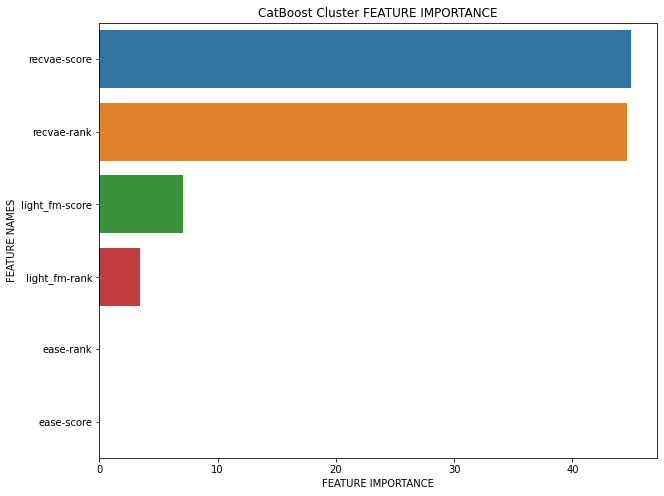

In [61]:
plot_feature_importance(model.feature_importances_, data_paths["valid"].iloc[:, 3:].columns, "CatBoost Cluster ")

In [65]:
from common_metrics.metrics.classification import FMeasure, Auc
f_metric = FMeasure()
auc_metric = Auc()
f_metric(prediction_score, data_paths["valid"]["target"].values)
auc_metric(prediction_score[:, 1], data_paths["valid"]["target"].values)

In [66]:
f_metric.get_metric(reset=True)

/home/y.konyushenko/venv/lib/python3.7/site-packages/common_metrics/backend.py:125: RuntimeWarning: invalid value encountered in true_divide


{'precision': [0.96371037, 0.0],
 'recall': [1.0, 0.0],
 'f1score': [0.9815199, 0.0]}

In [67]:
auc_metric.get_metric(reset=True)

{'auc': 0.5}

In [70]:
FEATURES = ['recvae-rank', 'recvae-score', 'ease-rank', 'ease-score', 'light_fm-rank', 'light_fm-score']

In [86]:
from tqdm import tqdm

def get_features(column = 'train'):
    features = []
    labels = []
    data = data_paths[column].iloc[:, 3:]
    for row in tqdm(data.iterrows()):
        current_f = []
        for f in FEATURES:
            current_f.append(data[f].values)
        features.append(current_f)
        labels.append(data_paths[column]['target'].values)
    return features, labels

In [ ]:
train_features, train_labels = get_features(column = 'train')

115403it [00:05, 20554.74it/s]

In [ ]:
len(train_features)

In [ ]:
import catboost
train_pool = catboost.Pool(train_features, train_labels)

In [ ]:
test_features, test_labels = get_features(column = 'valid')

In [ ]:
test_pool = catboost.Pool(test_features, test_labels)

In [83]:
train_labels

[1           0
 2           0
 3           0
 4           0
 7           0
            ..
 10538700    0
 10539150    0
 10560024    0
 10560030    0
 10580741    0
 Name: target, Length: 1126983, dtype: int64,
 1           0
 2           0
 3           0
 4           0
 7           0
            ..
 10538700    0
 10539150    0
 10560024    0
 10560030    0
 10580741    0
 Name: target, Length: 1126983, dtype: int64,
 1           0
 2           0
 3           0
 4           0
 7           0
            ..
 10538700    0
 10539150    0
 10560024    0
 10560030    0
 10580741    0
 Name: target, Length: 1126983, dtype: int64,
 1           0
 2           0
 3           0
 4           0
 7           0
            ..
 10538700    0
 10539150    0
 10560024    0
 10560030    0
 10580741    0
 Name: target, Length: 1126983, dtype: int64,
 1           0
 2           0
 3           0
 4           0
 7           0
            ..
 10538700    0
 10539150    0
 10560024    0
 10560030    0
 10580

In [3]:
user_test_path = '/mnt/new_products/y.konyushenko/CF/data/users.csv'
pd.read_csv(user_test_path)

,program_product_user_id,siebel_id,is_eternal_control,group_idx
0,938037,1-9K3ZP3G,False,1
1,1596254,4-T967TI1,False,1
2,634720,1-4CDLRY3,False,1
3,2420801,4-1HIA1HT8,False,1
4,4364901,5-3969KPPW,False,1
...,...,...,...,...
808545,63675912,5-2XTOUVR4S,False,1
808546,77271123,5-30KJBVP2M,False,1
808547,78386039,5-318WHAU5M,False,1
808548,82043831,5-33DR4SRL2,False,1


In [8]:
w_path = '/mnt/new_products/y.konyushenko/CF/data/w_matrix.tsv'
pd.read_csv(w_path, delimiter='\t', header=None)

,0,1,2
0,5-16WXRVBR6,RNFT,0.000393
1,5-23241CQSD,PIKK,0.024631
2,1-8O1S41K,SBER,0.000454
3,5-24ATFS9R8,ALRS,0.000437
4,5-1TDFXYMQ0,FXUS,0.211037
...,...,...,...
4926421,5-1HOTCTK93,TATNP,0.000716
4926422,5-J4Q85KFO,POLY,0.002624
4926423,5-YBZALVFC,SBER,0.000016
4926424,5-HIASQ9VZ,SNGS,0.000014


In [9]:
R_path = '/mnt/new_products/y.konyushenko/CF/data/R_matrix.tsv'
pd.read_csv(R_path, delimiter='\t', header=None)

,0,1
0,5-8ZGCH46I,TRUR
1,5-1Q96XTUJE,TATNP
2,5-323NDH956,TRUR
3,5-19MZPVG40,ROSN
4,5-2TREOAZXM,GAZP
...,...,...
15152318,5-2UAKSP7YK,TRUR
15152319,5-25WUF5BLQ,TRUR
15152320,5-2TJD5MDOS,ALRS
15152321,5-1B5H2DUE7,TCSG
